In [1]:
import os
import time
import sys
import scipy
import glob
import importlib

import pandas as pd
import numpy as np

import matplotlib as mpl
mpl.use('nbagg')
import seaborn as sns
import pylab as pl

from datetime import datetime

In [2]:
# import some custom funcs
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utils as util
import behavior as butil

In [4]:
util.set_sns_style(style='dark')

In [5]:
%matplotlib notebook

In [9]:
rootdir = '/Users/julianarhee/Library/CloudStorage/GoogleDrive-edge.tracking.ru@gmail.com\
/My Drive/Edge_Tracking/Data/jyr'

In [36]:
experiment = 'stripgrid'
session = '20221028'

# create fig ID
fig_id = os.path.join(rootdir.split(rootdir)[1], experiment, session)
print("Fig ID: {}".format(fig_id))
# Create output dir for figures
src_dir = os.path.join(rootdir, experiment, session)
save_dir = '/Users/julianarhee/Documents/rutalab/data/figures/{}/{}'.format(experiment, session)
save_dir = save_dir.replace(" ", "")

print("Saving figures to:{}    {}".format('\n', save_dir))
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

Fig ID: stripgrid/20221028
Saving figures to:
    /Users/julianarhee/Documents/rutalab/data/figures/stripgrid/20221028


In [37]:
log_files = sorted([k for k in glob.glob(os.path.join(src_dir, '*.log'))\
                if 'lossed tracking' not in k], key=util.natsort)
print("Found {} tracking files.".format(len(log_files)))
for fi, fpath in enumerate(log_files):
    dfn = os.path.split(fpath)[-1]
    print(fi, dfn)

Found 6 tracking files.
0 10282022-160309_hdc-sytGCaMP7f_fly1_test.log
1 10282022-161827_hdc-sytGCaMP7f_fly1_test.log
2 10282022-162303_hdc-sytGCaMP7f_fly1_test.log
3 10282022-163207_hdc-sytGCaMP7f_fly1_test.log
4 10282022-163810_hdc-sytGCaMP7f_fly1_test.log
5 10282022-164616_hdc-sytGCaMP7f_fly1_test.log


In [171]:
importlib.reload(butil)

<module 'behavior' from '/Users/julianarhee/Repositories/plume-tracking/behavior.py'>

In [172]:
cond=None
dlist = []
for fpath in log_files:
    air_only = '_Air' in fpath or '_air' in fpath
    #print(fpath, air_only)
    exp, date_str, fly_id, cond = butil.parse_info_from_file(fpath)
    print(date_str, fly_id, cond)
    df_ = butil.load_dataframe(fpath, mfc_id=None, verbose=False, cond=cond)
    dlist.append(df_)
df0 = pd.concat(dlist, axis=0)
# df0['trial_id'] = ['{}_{}'.format(fly_id, trial) for (fly_id, trial) in \
#                   df0[['fly_id', 'trial']].values]

# df0.loc[df0['condition']=='light', 'condition'] = 'lightonly'

10282022-160309 fly1 hdc-sytgcamp7f
10282022-161827 fly1 hdc-sytgcamp7f
10282022-162303 fly1 hdc-sytgcamp7f
10282022-163207 fly1 hdc-sytgcamp7f
10282022-163810 fly1 hdc-sytgcamp7f
10282022-164616 fly1 hdc-sytgcamp7f


In [173]:
df0[['fly_id', 'trial']].drop_duplicates().groupby('fly_id')['trial'].count()

fly_id
20221028-fly1    6
Name: trial, dtype: int64

In [174]:
fly_ids = sorted(df0['fly_id'].unique(), key=util.natsort)
print(fly_ids)

['20221028-fly1']


#### get borders

In [175]:
#odor_cond = 'hdc-sytgcamp7f'
odor_width=10
grid_sep=200
# get odor border for each fly
odor_borders={}
for (fly_id, trial), currdf in df0.groupby(['fly_id', 'trial']):
    ogrid = butil.get_odor_grid(currdf, 
                                odor_width=odor_width, grid_sep=grid_sep,
                                use_crossings=True, verbose=False)
    #print(trial, ogrid)
    #(odor_xmin, odor_xmax), = ogrid.values()
    currkey = '{}_{}'.format(fly_id, trial)
    odor_borders[currkey] = list(ogrid.values())
    #else:
    #   odor_borders.update({'{}_{}'.format(fly_id, trial): [(odor_xmin, odor_xmax)]})
#odor_borders

In [176]:
odor_borders

{'20221028-fly1_10282022-160309': [(29.455759823838996, 39.455759823838996)],
 '20221028-fly1_10282022-161827': [(69.497832991096, 79.497832991096)],
 '20221028-fly1_10282022-162303': [(26.390792759383004, 36.390792759383004),
  (-183.47862807311998, -173.4238978505988)],
 '20221028-fly1_10282022-163207': [(108.458553198151, 118.51547398015973)],
 '20221028-fly1_10282022-163810': [(-3.3396218232093497, 6.681811325854585)],
 '20221028-fly1_10282022-164616': [(-40.58574441609814, -30.549094551700623),
  (169.41726727210877, 179.4979979062)]}

## plot traces

In [177]:
hue_varname='instrip'
palette={True: 'r', False: 'w'}
start_at_odor = True
odor_width=10
odor_lc='lightgray'
odor_lw=0.5

In [178]:
/df0['condition'].unique()

array(['hdc-sytgcamp7f'], dtype=object)

<IPython.core.display.Javascript object>


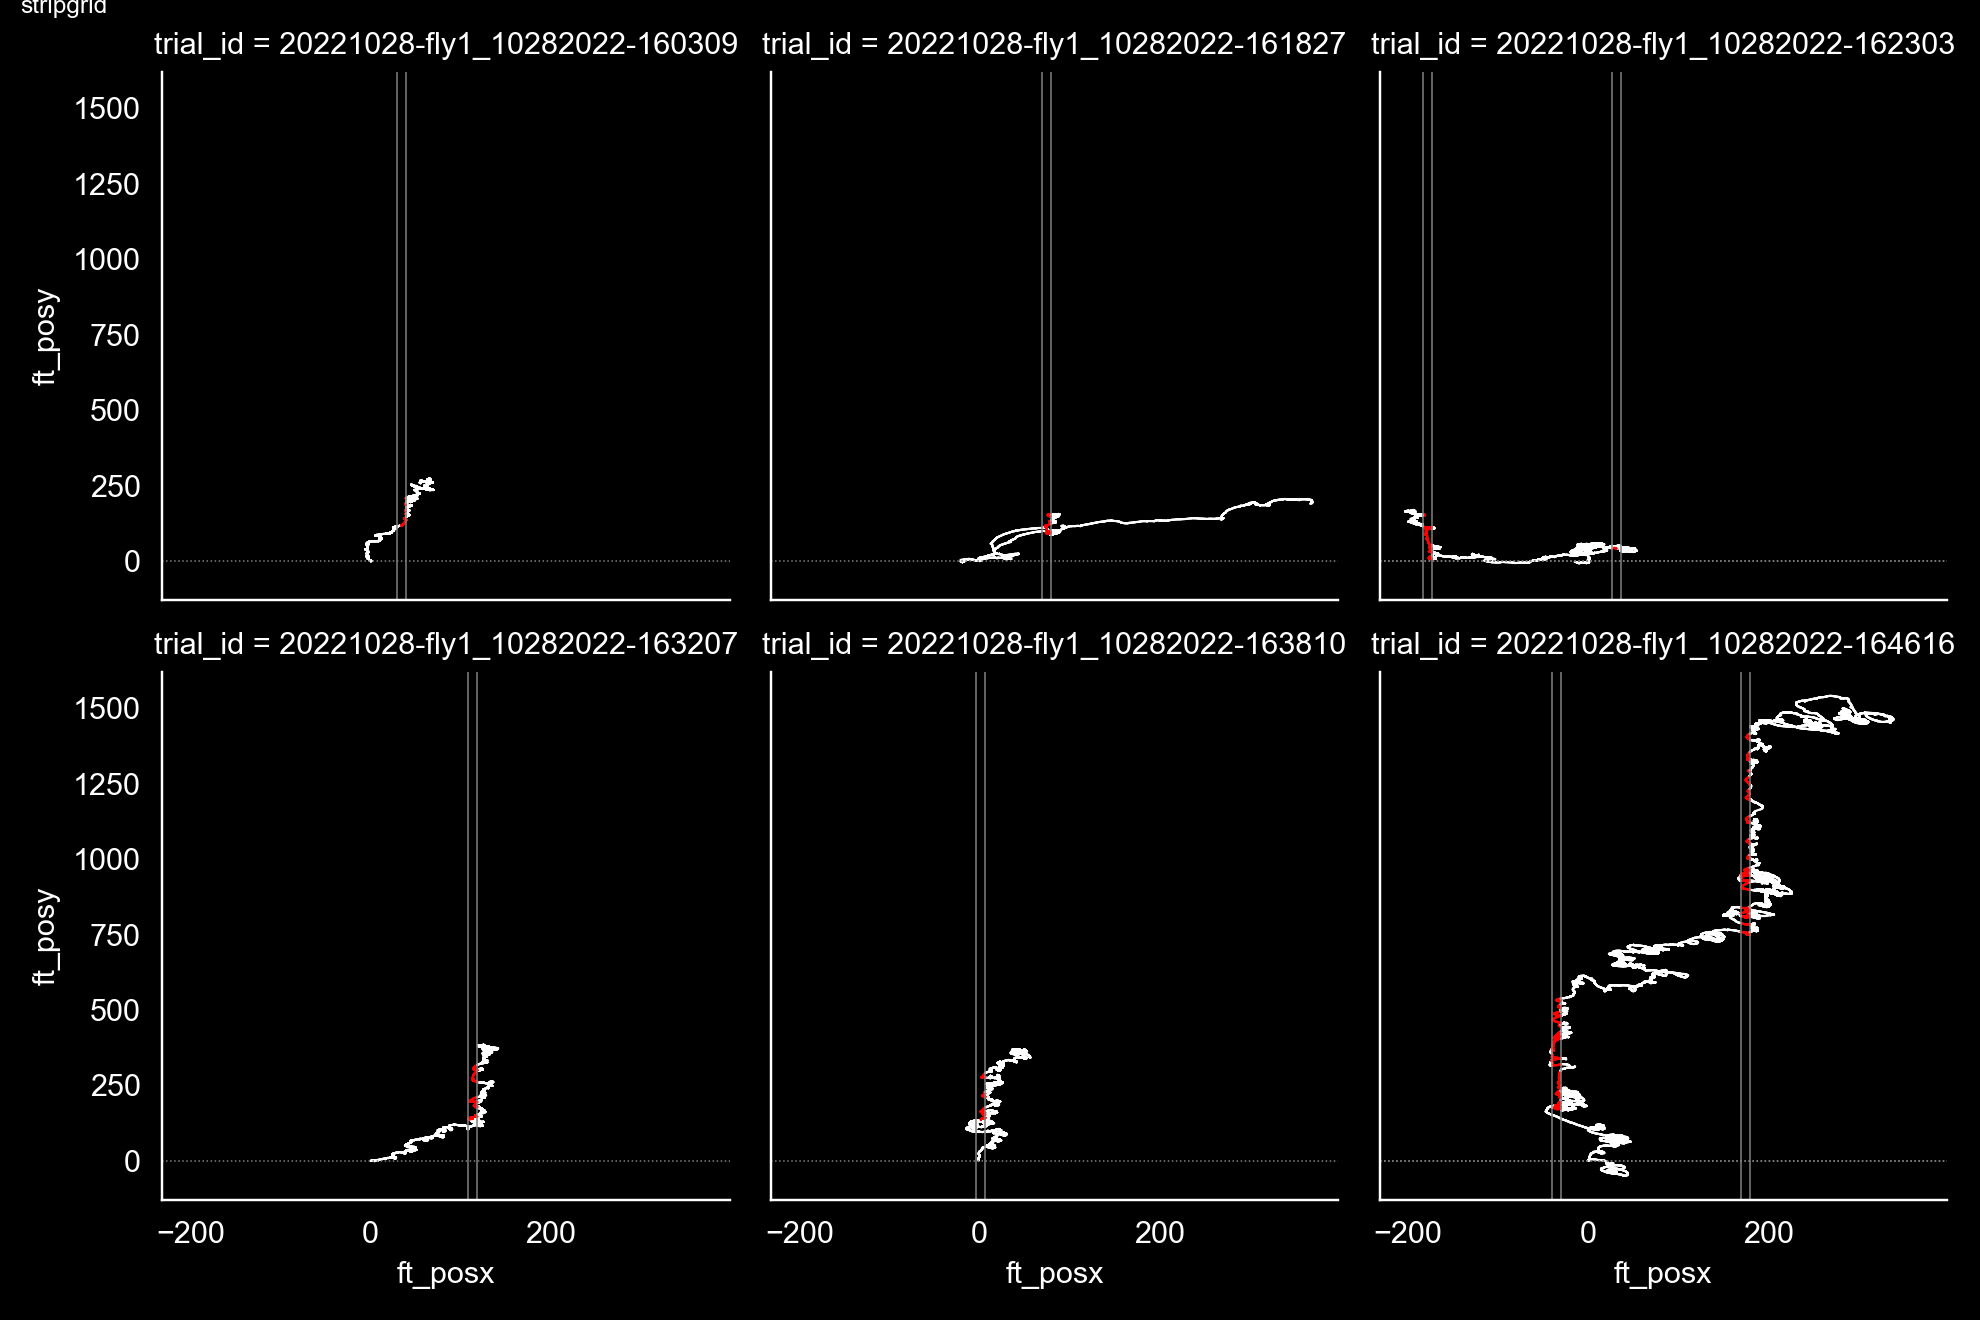

/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_1857/1061196155.py:13: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for ai, (trial_id, currdf) in enumerate(plotdf.groupby(['trial_id'])):


/Users/julianarhee/Documents/rutalab/data/figures/stripgrid/20221028


In [180]:
# xmin, xmax = (-500, 500)
# ymin, ymax = (-100, 1000)
# odor_xmin, odor_xmax = (-100, 100)
#conds=[odor_cond, 'air']
plotdf = df0.copy()
g = sns.FacetGrid(plotdf, col='trial_id', col_wrap=3)
g.map_dataframe(sns.scatterplot, x="ft_posx", y="ft_posy", hue=hue_varname,
               s=0.5, edgecolor='none', palette=palette) #, palette=palette)
pl.show()
util.label_figure(g.fig, experiment)

# add odor corridor to facet grid
for ai, (trial_id, currdf) in enumerate(plotdf.groupby(['trial_id'])):
    ax = g.axes[ai]
    for obound in odor_borders[trial_id]:
        odor_xmin, odor_xmax = obound
        butil.plot_odor_corridor(ax, odor_xmin=odor_xmin, odor_xmax=odor_xmax)

figname = 'trajectories_by_fly'
pl.savefig(os.path.join(save_dir, '{}.png'.format(figname))) #, dpi=dpi)
print(save_dir)